# PyTorch: MNIST dataset using GPU

In [1]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
dataset = MNIST(root='dataset/', download=True, transform=ToTensor())

In [3]:
def split_indices(n, val_pct):
    n_val = int(val_pct * n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [4]:
train_idxs, val_idxs = split_indices(len(dataset), val_pct=0.2)

len(train_idxs), len(val_idxs)

(48000, 12000)

In [5]:
batch_size = 128

train_sampler = SubsetRandomSampler(train_idxs)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_idxs)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [6]:
class MnistModel (nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.full_connecton_1 = nn.Linear(in_size, hidden_size[0])
        self.full_connecton_2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.full_connecton_3 = nn.Linear(hidden_size[1], out_size)
    
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = F.relu(self.full_connecton_1(xb))
        out = F.relu(self.full_connecton_2(out))
        out = self.full_connecton_3(out)
        return out

In [7]:
input_size = 28 * 28
hidden_size = [256, 32]
out_size = 10

In [8]:
model = MnistModel(input_size, hidden_size, out_size)

In [9]:
for t in model.parameters():
    print(t.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([32, 256])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [10]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('loss', loss.item())
    break

print('outputs.shape', outputs.shape)
print('Sample outputs:\n', outputs[:2].data)

images.shape: torch.Size([128, 1, 28, 28])
loss 2.3170006275177
outputs.shape torch.Size([128, 10])
Sample outputs:
 tensor([[ 0.0543,  0.1856,  0.1103,  0.0230,  0.1952, -0.0782,  0.0443, -0.2218,
         -0.1210,  0.2141],
        [ 0.0247,  0.1930,  0.0982,  0.0259,  0.1652, -0.0627,  0.0564, -0.2180,
         -0.1152,  0.2132]])


### Using GPU

In [11]:
torch.cuda.is_available()

True

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [15]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [16]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [18]:
for xb, yb in val_loader:
    print(xb.device)
    print(yb)
    break

cuda:0
tensor([9, 3, 7, 2, 2, 3, 4, 9, 0, 3, 6, 3, 8, 3, 1, 3, 0, 4, 3, 8, 8, 2, 1, 1,
        8, 6, 9, 6, 0, 8, 1, 5, 1, 0, 6, 1, 9, 4, 7, 1, 2, 1, 5, 3, 3, 4, 6, 5,
        0, 1, 0, 7, 9, 3, 8, 6, 1, 4, 9, 1, 1, 1, 4, 4, 0, 7, 2, 5, 9, 4, 1, 2,
        3, 9, 0, 7, 3, 4, 1, 8, 9, 5, 1, 5, 9, 1, 2, 8, 1, 4, 5, 0, 1, 5, 1, 5,
        4, 2, 3, 6, 8, 8, 3, 5, 8, 3, 1, 8, 6, 0, 4, 8, 2, 8, 7, 1, 4, 6, 0, 2,
        4, 0, 8, 2, 2, 6, 0, 7], device='cuda:0')


In [19]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [20]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [21]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, opt_fn=None, metric=None):
    losses, metrics = [], []

    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)
        
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        losses.append(val_loss)
        metrics.append(val_metric)

        if metric is None:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch + 1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.5f}, {}: {:.5f}'.format(epoch + 1, epochs, val_loss, metric.__name__, val_metric))
    
    return losses, metrics

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [23]:
input_size = 28 * 28
hidden_size = [256, 32]
out_size = 10
model = MnistModel(input_size, hidden_size, out_size)

to_device(model, device)

MnistModel(
  (full_connecton_1): Linear(in_features=784, out_features=256, bias=True)
  (full_connecton_2): Linear(in_features=256, out_features=32, bias=True)
  (full_connecton_3): Linear(in_features=32, out_features=10, bias=True)
)

In [24]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, val_loader, metric=accuracy)
print('Loss: {:.5f}, Accuracy: {:.5f}'.format(val_loss, val_acc))

Loss: 2.31327, Accuracy: 0.09417


In [25]:
losses, metrics = fit(25, 0.1, model, F.cross_entropy, train_loader, val_loader, metric=accuracy)

Epoch [1/25], Loss: 0.35796, accuracy: 0.90042
Epoch [2/25], Loss: 0.27608, accuracy: 0.91942
Epoch [3/25], Loss: 0.21855, accuracy: 0.93858
Epoch [4/25], Loss: 0.17212, accuracy: 0.95017
Epoch [5/25], Loss: 0.15990, accuracy: 0.95383
Epoch [6/25], Loss: 0.13364, accuracy: 0.96075
Epoch [7/25], Loss: 0.12261, accuracy: 0.96258
Epoch [8/25], Loss: 0.10744, accuracy: 0.96817
Epoch [9/25], Loss: 0.10014, accuracy: 0.96992
Epoch [10/25], Loss: 0.09861, accuracy: 0.97192
Epoch [11/25], Loss: 0.08864, accuracy: 0.97400
Epoch [12/25], Loss: 0.08734, accuracy: 0.97442
Epoch [13/25], Loss: 0.08663, accuracy: 0.97425
Epoch [14/25], Loss: 0.08002, accuracy: 0.97675
Epoch [15/25], Loss: 0.07904, accuracy: 0.97783
Epoch [16/25], Loss: 0.08494, accuracy: 0.97533
Epoch [17/25], Loss: 0.07953, accuracy: 0.97750
Epoch [18/25], Loss: 0.07899, accuracy: 0.97792
Epoch [19/25], Loss: 0.07728, accuracy: 0.97758
Epoch [20/25], Loss: 0.07502, accuracy: 0.97892
Epoch [21/25], Loss: 0.07493, accuracy: 0.97842
E

In [26]:
losses_2, metrics_2 = fit(25, 0.05, model, F.cross_entropy, train_loader, val_loader, metric=accuracy)

Epoch [1/25], Loss: 0.07379, accuracy: 0.97933
Epoch [2/25], Loss: 0.07466, accuracy: 0.97917
Epoch [3/25], Loss: 0.07413, accuracy: 0.98000
Epoch [4/25], Loss: 0.07385, accuracy: 0.97942
Epoch [5/25], Loss: 0.07462, accuracy: 0.97908
Epoch [6/25], Loss: 0.07422, accuracy: 0.97925
Epoch [7/25], Loss: 0.07448, accuracy: 0.98000
Epoch [8/25], Loss: 0.07496, accuracy: 0.97950
Epoch [9/25], Loss: 0.07480, accuracy: 0.97967
Epoch [10/25], Loss: 0.07659, accuracy: 0.97942
Epoch [11/25], Loss: 0.07531, accuracy: 0.97967
Epoch [12/25], Loss: 0.07563, accuracy: 0.98033
Epoch [13/25], Loss: 0.07528, accuracy: 0.97975
Epoch [14/25], Loss: 0.07614, accuracy: 0.97925
Epoch [15/25], Loss: 0.07506, accuracy: 0.98017
Epoch [16/25], Loss: 0.07722, accuracy: 0.97875
Epoch [17/25], Loss: 0.07660, accuracy: 0.98017
Epoch [18/25], Loss: 0.07689, accuracy: 0.97975
Epoch [19/25], Loss: 0.07786, accuracy: 0.97950
Epoch [20/25], Loss: 0.07715, accuracy: 0.97950
Epoch [21/25], Loss: 0.07705, accuracy: 0.97958
E

In [27]:
accuracies = [val_acc] + metrics + metrics_2
total_losses = [val_loss] + losses + losses_2

Text(0.5, 1.0, 'Loss vs Number of epochs')

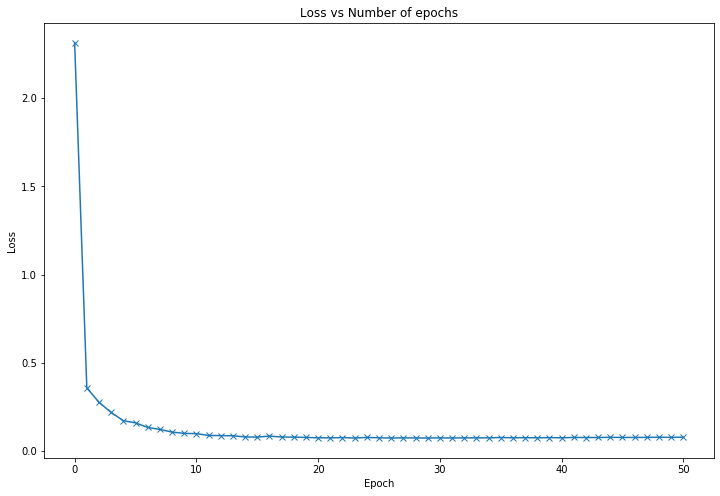

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(total_losses, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Number of epochs')

Text(0.5, 1.0, 'Accuracy vs Number of epochs')

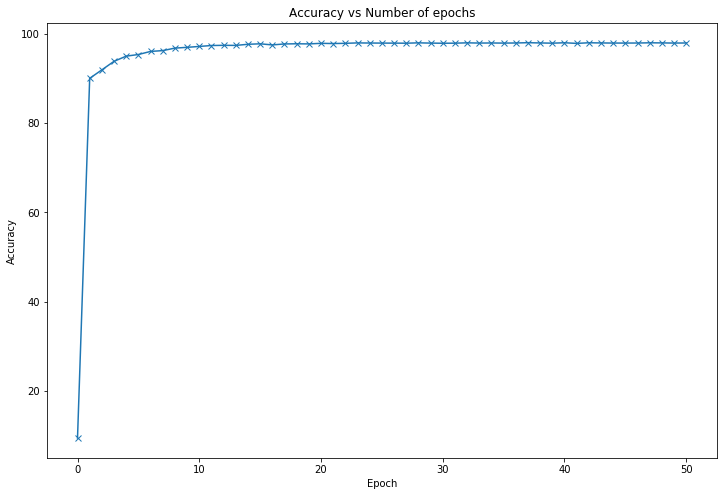

In [29]:
plt.figure(figsize=(12, 8))
plt.plot([x * 100 for x in accuracies], '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of epochs')

In [30]:
torch.save(model.state_dict(), 'models/mnist-dnn.pth')

In [31]:
def predict_img(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [32]:
test_dataset = MNIST(root='dataset/', train=False, transform=ToTensor())

In [33]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=batch_size), device)
test_loss, total, test_acc = evaluate(model, F.cross_entropy, test_loader, metric=accuracy)
print('Loss: {:.5f}, Accuray: {:.5f}'.format(test_loss, test_acc))

Loss: 0.07059, Accuray: 0.98110


Text(0.5, 1.0, 'Label: 7 Predicted: 7')

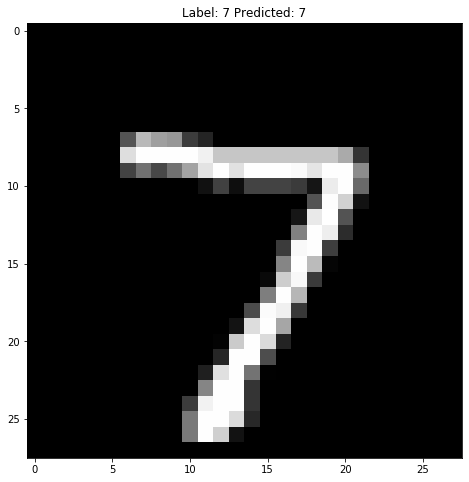

In [34]:
image = test_dataset[0][0]
label = test_dataset[0][1]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(to_device(image, device), model)))

Text(0.5, 1.0, 'Label: 0 Predicted: 0')

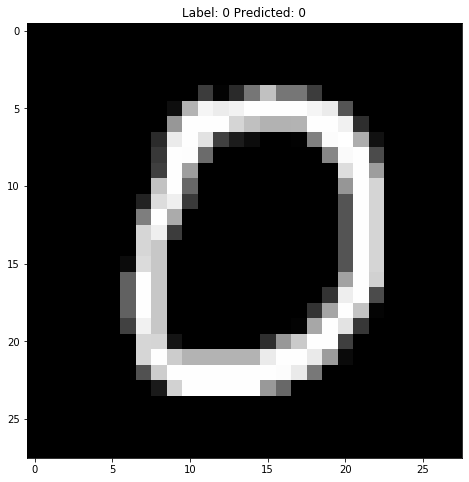

In [35]:
image = test_dataset[10][0]
label = test_dataset[10][1]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(to_device(image, device), model)))

Text(0.5, 1.0, 'Label: 9 Predicted: 9')

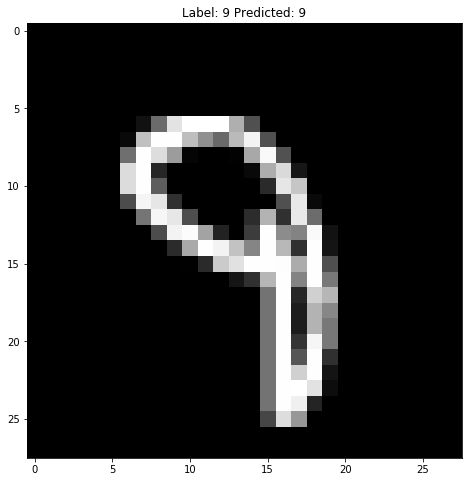

In [36]:
image = test_dataset[193][0]
label = test_dataset[193][1]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(to_device(image, device), model)))

Text(0.5, 1.0, 'Label: 2 Predicted: 2')

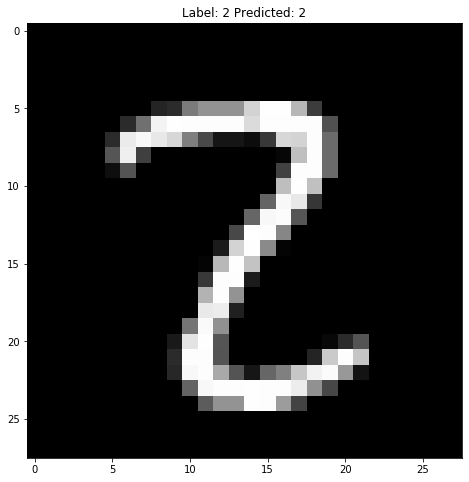

In [37]:
image = test_dataset[1839][0]
label = test_dataset[1839][1]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(to_device(image, device), model)))

Text(0.5, 1.0, 'Label: 7 Predicted: 7')

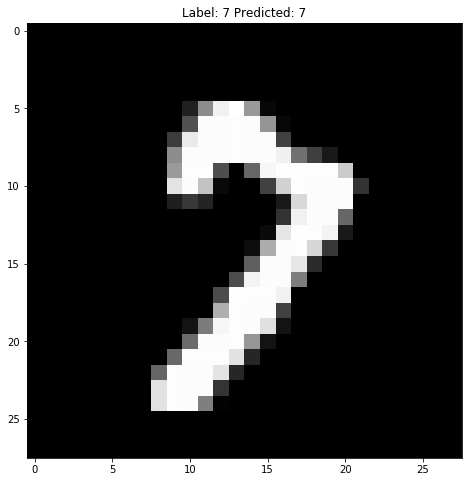

In [38]:
image = test_dataset[6954][0]
label = test_dataset[6954][1]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(to_device(image, device), model)))